In [1]:
import joblib
import pandas as pd
import json
import pickle

from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

#https://www.kaggle.com/slundberg/interpreting-a-lightgbm-model
#https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html
#https://slundberg.github.io/shap/notebooks/plots/decision_plot.html

In [2]:
model = joblib.load(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\fold1.joblib")

In [3]:
explainer = shap.TreeExplainer(model)

In [4]:
df = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\train_df_fe_all.csv")

with open(r"D:\29 CS5228\03 Project\HDBResalePrice\src\utils\params.json") as json_file:
    params = json.load(json_file)
nums = params['num_cols']+params['aux_cols']
cates = params['cate_cols']
cols = nums + cates
for col in nums:
    df[col] = df[col].astype(float)
for col in cates:
    df[col] = df[col].apply(lambda x: str(x).lower())
for col in cates:
    df[col] = df[col].astype('category')

X = df[cols].copy()

In [5]:
import random
import numpy as np
random.seed(1234)

In [6]:
ixes = random.sample(list(X.index), 5000)
shap_values = explainer.shap_values(X.loc[ixes])

In [7]:
with open("train_shap_values_5000.pkl", "wb") as f:
    pickle.dump(shap_values, f)

In [60]:
with open('ixes_5000.txt', 'w') as f:
    for item in ixes:
        f.write("%s\n" % item)

# Visualise

In [57]:
with open(r"D:\29 CS5228\03 Project\FeatImpStudy\train_shap_values.pkl", "rb") as input_file:
    shap_values = pickle.load(input_file)

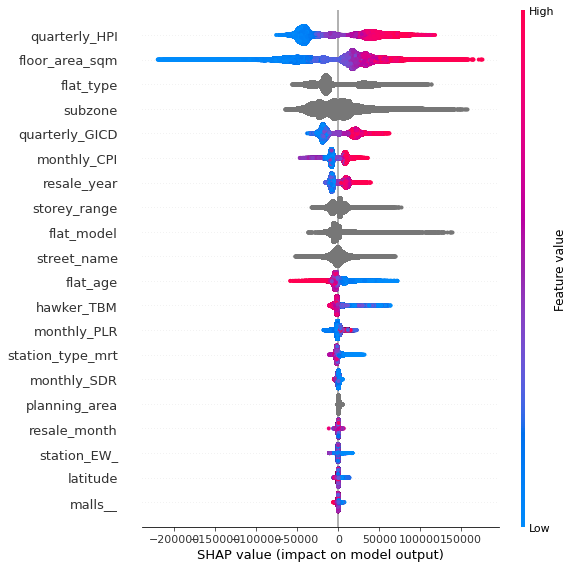

In [64]:
shap.summary_plot(shap_values, X, max_display=20)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


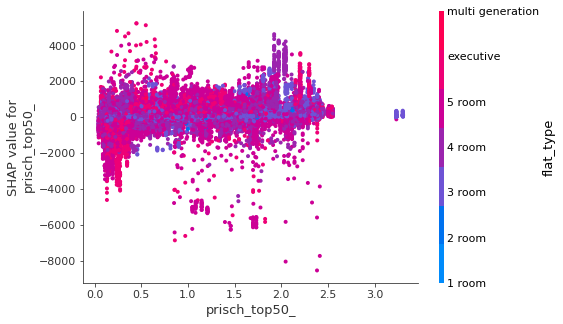

In [63]:
shap.dependence_plot("prisch_top50_", shap_values, X)

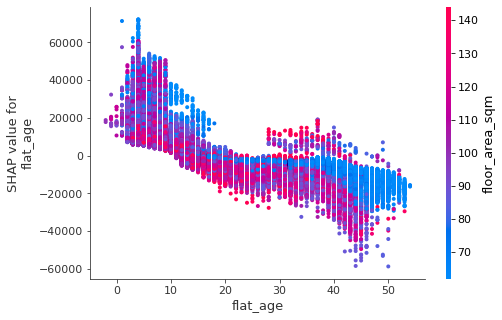

In [62]:
shap.dependence_plot("flat_age", shap_values, X)

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


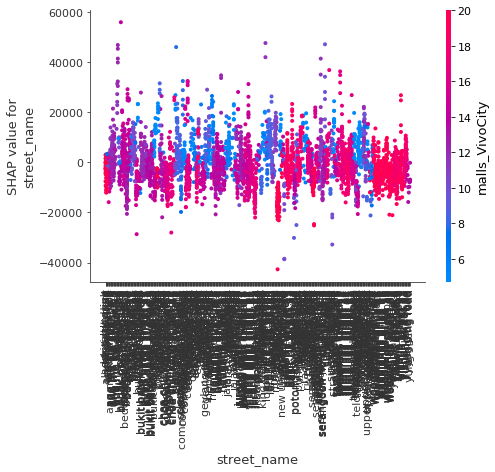

In [11]:
shap.dependence_plot("street_name", shap_values, X.loc[ixes])

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


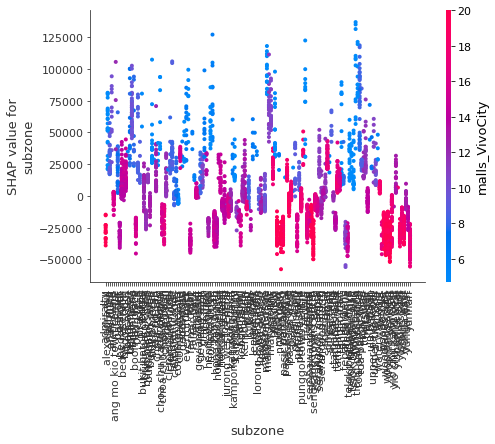

In [12]:
shap.dependence_plot("subzone", shap_values, X.loc[ixes])

# Error Analysis

In [13]:
pred_train = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\pred_train.csv")
pred_test = pd.read_csv(r"D:\29 CS5228\03 Project\HDBResalePrice\outs\lgb\0407_16497.04867\pred_test.csv")
pred = pd.concat([pred_train, pred_test], axis=0)
pred = pred.sort_values(by='index').reset_index(drop=True)
pred.head()

,index,pred
0,0,239608.817606
1,1,427444.972144
2,2,366287.380222
3,3,148183.791614
4,4,313251.785500


In [14]:
y=df['resale_price']
pred=pred['pred']

##### overprediction

In [48]:
weighted_errors = [(j/i-1) for i,j in zip(y, pred)]
error_ixes = [i for i, val in enumerate(weighted_errors) if val>1.5]
error_ixes

[35587, 56334, 133171, 138298, 145407, 273109, 313369]

In [56]:
def shap_force_plot(X, y, y_pred, ix):
    shap.initjs()
    shap_values_2 = explainer.shap_values(X.loc[[ix]])
    print(f'row: {ix}, actual: {y[ix]}, pred: {y_pred[ix]}')
    print({k:v for k,v in zip(X.columns, list(X.loc[ix]))})
    return shap.force_plot(explainer.expected_value, shap_values_2[0,:], features=cols)
    
shap_force_plot(X, y, pred, 35587)

row: 35587, actual: 94500.0, pred: 242197.3805526213
{'block': 0.0, 'flat_age': 31.0, 'resale_year': 2001.0, 'floor_area_sqm': 118.0, 'latitude': 1.3078246487802498, 'longitude': 103.80062978717699, 'commercial_CBD': 6.433, 'commercial_type_CR': 6.433, 'commercial_type_IEBP': 1.6411, 'commercial_type_IEPB': 11.7593, 'commercial_type_BN': 1.1825, 'commercial_type_IHL': 2.3444, 'hawker_ECLFV': 14.86, 'hawker_NFC': 4.374, 'hawker_CRB89': 9.5994, 'hawker_OARB51OARFCSM': 9.4728, 'hawker_CRB': 9.6227, 'hawker_HVMFC': 0.7295, 'hawker_BFC': 17.2698, 'hawker_CCFC': 9.6439, 'hawker_TBM': 4.3723, 'hawker_BPHC': 8.437000000000001, 'hawker_GMFC': 7.0524, 'hawker_YPHC': 13.9221, 'hawker_OTH': 16.3109, 'hawker_KAHC': 14.7105, 'hawker__': 0.13699999999999998, 'hawker_highrating_': 4.3723, 'hawker_established_': 0.7295, 'malls_GWC': 3.8354, 'malls_IO': 3.5034, 'malls_TSMBS': 6.9874, 'malls_NAC': 3.8126, 'malls_PS': 4.9897, 'malls_SC': 6.5983, 'malls_OTH': 16.3594, 'malls_CA': 21.6012, 'malls_JCA': 21.8

In [52]:
shap_force_plot(X, y, pred, 138298)

row: 138298, actual: 83700.0, pred: 242914.4940189248
{'block': 0.0, 'flat_age': 24.0, 'resale_year': 2000.0, 'floor_area_sqm': 130.0, 'latitude': 1.34700367367084, 'longitude': 103.71421641358499, 'commercial_CBD': 16.9752, 'commercial_type_CR': 2.6747, 'commercial_type_IEBP': 2.2587, 'commercial_type_IEPB': 20.1269, 'commercial_type_BN': 9.5616, 'commercial_type_IHL': 3.5161, 'hawker_ECLFV': 24.8527, 'hawker_NFC': 14.4787, 'hawker_CRB89': 19.2194, 'hawker_OARB51OARFCSM': 19.5586, 'hawker_CRB': 19.1323, 'hawker_HVMFC': 9.8221, 'hawker_BFC': 26.9827, 'hawker_CCFC': 17.0399, 'hawker_TBM': 14.8563, 'hawker_BPHC': 7.3462, 'hawker_GMFC': 17.3456, 'hawker_YPHC': 16.9228, 'hawker_OTH': 25.1335, 'hawker_KAHC': 14.1316, 'hawker__': 0.2444, 'hawker_highrating_': 14.1316, 'hawker_established_': 7.3462, 'malls_GWC': 14.3832, 'malls_IO': 13.9314, 'malls_TSMBS': 17.5324, 'malls_NAC': 14.2562, 'malls_PS': 15.4228, 'malls_SC': 17.0424, 'malls_OTH': 25.183000000000003, 'malls_CA': 30.5098, 'malls_JCA'

In [53]:
shap_force_plot(X, y, pred, 313369)

row: 313369, actual: 144000.0, pred: 392042.54769121023
{'block': 0.0, 'flat_age': 21.0, 'resale_year': 2000.0, 'floor_area_sqm': 149.0, 'latitude': 1.3214382605739698, 'longitude': 103.765901268051, 'commercial_CBD': 10.5798, 'commercial_type_CR': 3.762, 'commercial_type_IEBP': 2.1785, 'commercial_type_IEPB': 14.8494, 'commercial_type_BN': 3.1608, 'commercial_type_IHL': 2.7514, 'hawker_ECLFV': 18.7825, 'hawker_NFC': 8.2708, 'hawker_CRB89': 13.2998, 'hawker_OARB51OARFCSM': 13.4133, 'hawker_CRB': 13.2653, 'hawker_HVMFC': 3.4271, 'hawker_BFC': 21.0744, 'hawker_CCFC': 12.1563, 'hawker_TBM': 8.4497, 'hawker_BPHC': 6.3609, 'hawker_GMFC': 11.0854, 'hawker_YPHC': 14.4803, 'hawker_OTH': 19.6942, 'hawker_KAHC': 13.7531, 'hawker__': 0.9112, 'hawker_highrating_': 8.2708, 'hawker_established_': 3.4271, 'malls_GWC': 7.979, 'malls_IO': 7.5908, 'malls_TSMBS': 11.1339, 'malls_NAC': 7.9109, 'malls_PS': 9.0873, 'malls_SC': 10.7065, 'malls_OTH': 19.7437, 'malls_CA': 25.0657, 'malls_JCA': 25.2468, 'malls_

##### underprediction

In [49]:
error_ixes = [i for i, val in enumerate(weighted_errors) if val<-0.35]
error_ixes

[169923, 184475, 195954, 212225, 386268]

In [65]:
np.array(y)[error_ixes]

array([337500.   , 343800.   , 191700.   , 799999.992, 154800.   ])

In [66]:
shap_force_plot(X, y, pred, 212225)

row: 212225, actual: 799999.9920000002, pred: 414947.9485369845
{'block': 0.0, 'flat_age': 49.0, 'resale_year': 2017.0, 'floor_area_sqm': 84.0, 'latitude': 1.2965892359168, 'longitude': 103.804175434758, 'commercial_CBD': 5.7031, 'commercial_type_CR': 5.7031, 'commercial_type_IEBP': 1.7119, 'commercial_type_IEPB': 12.0397, 'commercial_type_BN': 1.0141, 'commercial_type_IHL': 2.6851, 'hawker_ECLFV': 14.5188, 'hawker_NFC': 4.3179, 'hawker_CRB89': 9.53, 'hawker_OARB51OARFCSM': 9.1711, 'hawker_CRB': 9.5991, 'hawker_HVMFC': 1.9124, 'hawker_BFC': 17.0257, 'hawker_CCFC': 10.2282, 'hawker_TBM': 3.4084, 'hawker_BPHC': 9.7438, 'hawker_GMFC': 6.6734, 'hawker_YPHC': 14.9728, 'hawker_OTH': 16.3731, 'hawker_KAHC': 15.9644, 'hawker__': 0.3898, 'hawker_highrating_': 3.4084, 'hawker_established_': 1.9124, 'malls_GWC': 3.112, 'malls_IO': 3.1894, 'malls_TSMBS': 6.2312, 'malls_NAC': 3.4402, 'malls_PS': 4.5477, 'malls_SC': 6.0735, 'malls_OTH': 16.4206, 'malls_CA': 21.5797, 'malls_JCA': 21.8013, 'malls_Vivo

In [50]:
shap_force_plot(X, y, pred, 386268)

row: 386268, actual: 154800.0, pred: 96925.97289729324
{'block': 0.0, 'flat_age': 25.0, 'resale_year': 2000.0, 'floor_area_sqm': 68.0, 'latitude': 1.34572728320792, 'longitude': 103.711027373165, 'commercial_CBD': 17.247, 'commercial_type_CR': 2.9141, 'commercial_type_IEBP': 1.9808, 'commercial_type_IEPB': 20.488000000000003, 'commercial_type_BN': 9.8118, 'commercial_type_IHL': 3.175, 'hawker_ECLFV': 25.1776, 'hawker_NFC': 14.7842, 'hawker_CRB89': 19.5524, 'hawker_OARB51OARFCSM': 19.8743, 'hawker_CRB': 19.4684, 'hawker_HVMFC': 10.092, 'hawker_BFC': 27.3201, 'hawker_CCFC': 17.4084, 'hawker_TBM': 15.1065, 'hawker_BPHC': 7.7257, 'hawker_GMFC': 17.647000000000006, 'hawker_YPHC': 17.3001, 'hawker_OTH': 25.492, 'hawker_KAHC': 14.4778, 'hawker__': 0.2089, 'hawker_highrating_': 14.4778, 'hawker_established_': 7.7257, 'malls_GWC': 14.6498, 'malls_IO': 14.2178, 'malls_TSMBS': 17.8028, 'malls_NAC': 14.5419, 'malls_PS': 15.7112, 'malls_SC': 17.3315, 'malls_OTH': 25.5416, 'malls_CA': 30.8697, 'mall

In [25]:
def shap_decision_plot(X, y, y_pred, ix):
    shap.initjs()
    shap_values_2 = explainer.shap_values(X.loc[[ix]])
    shap_interaction_values = explainer.shap_interaction_values(X.loc[[ix]])
    print(f'row: {ix}, actual: {y[ix]}, pred: {y_pred[ix]}')
    return shap.decision_plot(explainer.expected_value, shap_interaction_values, features=cols, link='logit')
shap_decision_plot(X, y, pred, 3767)

ValueError: could not convert string to float: '3 room'